In [ ]:
#export 
import numpy as np
from tqdm.auto import tqdm
from copy import deepcopy
from functools import partial
from fastcore.all import *
from joblib import Parallel, delayed

from bounce.agents import DQNAgent, DQN, BrFSAgent, MCAgent
from bounce.environment import SDPEnvironment
from bounce.utils import T, state_in_list, state2str
from bounce.utils import load_checkpoint, save_model, load_model

import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
# default_exp training

In [ ]:
#hide
from nbdev.showdoc import show_doc
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Training
> Functionalities to train the different agents.

Here we provide `Trainer` objects that can train several agents in parallel. These generate a set of independent agents and their respective environments to perform the training. 

Each `Trainer` relies on an external function that determines the way the agent explores the state space. For instance, the `DQNTrainer` relies on the `train_agent` function and the `MCTrainer` relies on the `explore_mc` function. 

## Deep Q-learning trainer

The `DQNTrainer` handles the training of the deep reinforcement learning agent. 

In [ ]:
#export
class DQNTrainer:
    "Trainer for DQN agents"
    @delegates(DQNAgent.__init__)
    def __init__(self, N, H, budget_profile, reward_fun="energy_norm", 
                 n_agents=1, models=None, arch=DQN, n_jobs=1, **kwargs):
        self.env = SDPEnvironment(N, H, budget_profile, reward_criterion=reward_fun)
        self.arch = arch
        self.agent_kwargs = kwargs
        self.n_agents = n_agents
        self.parallel = Parallel(n_jobs=n_jobs)
        self.models = models
        self._def_reset()
        self.reset()
        
    def train(self, episodes, id0=0, **kwargs):
        "Performs `n_trains` in parallel."
        train_setups = zip(self.envs, self.agents)
        p_train = partial(train_agent, episodes=episodes, **kwargs)
        results = self.parallel(delayed(p_train)(env, agent, train_id=k+id0) for k, (env,agent) in enumerate(train_setups))
        return self._process_results(results)     
        
    def change_environment(self, H=None, budget_profile=None, reward_fun="energy_norm"):
        "Changes the environment parameters"
        if H is None: H = self.env.H
        if budget_profile is None: budget_profile = self.env.param_profile
        self.env = SDPEnvironment(self.env.N, H, budget_profile, reward_criterion="energy_norm")
        if self.envs is not None: 
            self.envs = [deepcopy(self.env) for _ in range(len(self.envs))]
            
    def set_agent_attrs(self, **attrs):
        "Changes values of the current agents, e.g., `agent.epsilon`"
        for attribute, value in attrs.items():
            [setattr(agent, attribute, value) for agent in self.agents]
        
    def _process_results(self, results):
        "Processes the results as they come out of the parallel"
        agents, envs, final_rewards, final_params, final_energies, final_optims, expl_optims = [], [], [], [], [], [], []
        visited_states, visited_energies, visited_params, oracle_rewards, visited_rewards = [], [], [], [], []
        for result in results:
            agent, env, rewards, params, energies, opt_eval, opt_exp = result["training"]
            agents.append(agent); envs.append(env); final_rewards.append(rewards); final_params.append(params)
            final_energies.append(energies); final_optims.append(opt_eval); expl_optims.append(opt_exp)   
            
            states, energies, params, o_rewards, env_rewards = result["exploration"]
            visited_states.append(states); visited_energies.append(energies); visited_params.append(params)
            oracle_rewards.append(o_rewards); visited_rewards.append(env_rewards)
            
        self.agents, self.envs = agents, envs  
        models = [agent.model for agent in agents]
        training_results = {'models': models, 'envs': envs, 'rewards': final_rewards, 'params': final_params, 
                            'energies': final_energies, 'eval_optims': final_optims, 'expl_optims': expl_optims}
        exploration_results = {'agents': models, 'envs': envs, 'visited_states': visited_states, 'energies': visited_energies, 
                               'params': visited_params, 'oracle_rewards': oracle_rewards, 'visited_rewards': visited_rewards}
        return {'training': training_results, 'exploration': exploration_results}
    
    def _get_agent(self, model=None):
        "Instantiates the agent given an architecture `arch`."
        if model is None: 
            in_dim = len(self.env.state); out_dim = in_dim + 1
            net = self.arch(in_dim, out_dim)
        else: 
            self.arch = model.__class__
            net = deepcopy(model)
        return DQNAgent(self.env.N, net, **self.agent_kwargs)
    
    def _def_reset(self):
        "Defines the reset method."
        if self.models is None: 
            self.reset = self._reset_from_scratch
        else:                
            self.n_agents = len(self.models)
            self.reset = self._reset_from_models
    
    def _reset_from_scratch(self):
        "Restarts the agents and everinoments creating `n_agents` instances"
        self.agents = [self._get_agent() for _ in range(self.n_agents)]
        self.envs = [deepcopy(self.env) for _ in range(self.n_agents)]
        
    def _reset_from_models(self):
        "Restarts the agents and environments from the pre-trained models"
        self.agents = [self._get_agent(model) for model in self.models]
        self.envs = [deepcopy(self.env) for _ in range(len(self.models))]

The `DQNTrainer` depends entirely on the `train_agent` function. This, in itself, relies on several inner functionalities shown below. 

In [ ]:
#export    
def train_agent(env, agent, episodes, time_steps=20, opt=None, best_ref=None,
                evaluate=True, break_opt=False, train_id=None, ckp=20, save=True):
    "Trains an agent given an environment."
    if train_id is None: train_id = np.random.randint(100, 1000)
    if isinstance(episodes, int): episodes = (episodes,)
    final_reward, final_params, final_energies, final_optimals, optimal_states = [], [], [], [], []
    visited_states, visited_energies, visited_params, oracle_rewards, visited_rewards = [], [], [], [], []
    ckp_dir = Path("../trained_models/checkpoints/"); ckp_dir.mkdir(parents=True, exist_ok=True)
    ckp_name = None
    breaking = False
                   
    for e in tqdm(range(*episodes)):
        state = deepcopy(env.reset())  # Reset environment at the beginning of each game
        optims = []
        for _ in range(time_steps):           
            next_state, action, energy, params, err = step(state, agent, env, e) # perform step
            agent.memorize(state, action, energy, params, next_state)            # memorize outcome
            state = deepcopy(next_state)                                               
            
            if opt is not None: optims.append(check_optim(opt, energy, params)) # Track optims during exploration
            if not state_in_list(state, visited_states): 
                visited_states.append(state)
                visited_energies.append(energy)
                visited_params.append(params)
                visited_rewards.append(get_reward(env, energy, params))
                if best_ref is not None:
                    oracle_rewards.append(get_reward(env, energy, params, best_ref=best_ref))
                    
            if break_opt and check_optim(opt, energy, params): breaking = True; break

        if len(agent.memory) >= agent.batch_size//5:   
            agent.replay(env)                                                  # Replay to learn                        
            
        if e%agent.target_update == 0:
            agent.target_net.load_state_dict(agent.model.state_dict())         # Update target network
            
        if evaluate:
            reward, energy, params = evaluate_agent(agent, env, time_steps, e) # Evaluate agent (deterministic policy)
            final_reward.append(reward) 

        final_params.append(params)
        final_energies.append(energy)
        if opt is not None: 
            final_optimals.append(check_optim(opt, energy, params))
            optimal_states.append(np.mean(optims))
            
        # Save checkpoint    
        if e%ckp == 0 or e==episodes[0]-1 or breaking: 
            if ckp_name is not None: (ckp_dir/ckp_name).unlink()
            ckp_name = f"ckp_N{agent.N}_{env.H.model}_{env.param_profile.max_params}_id{train_id}_e{e}.pt"
            checkpoint = {'model': agent.model, 'model_state_dict': agent.model.state_dict, 'env': env,
                   'final_reward': final_reward, 'final_params': final_params, 'final_energies': final_energies,
                   'eval_optims': final_optimals, 'expl_optims': optimal_states, 'visited_states': visited_states, 
                   'visited_energies': visited_energies, 'visited_params': visited_params, 
                   'oracle_rewards': oracle_rewards, 'visited_rewards': visited_rewards}
            torch.save(checkpoint, ckp_dir/ckp_name)
            env.save_memory()
            
        if breaking: break
        
    # Once trained, save updated memory file and trained agent
    env.save_memory()
    if save: save_model(agent, env.H, env.param_profile.max_params, train_id)
        
    return {'training': (agent, env, final_reward, final_params, final_energies, final_optimals, optimal_states),
            'exploration': (visited_states, visited_energies, visited_params, oracle_rewards, visited_rewards)}

DQNTrainer.train = delegates(to=train_agent)(DQNTrainer.train)

To train an agent, provide the environment `env` containing the all the details about the problem that is to be solved and the `agent`, which is an initialized `DQNAgent`. The learning process is structured in a number of `episodes` of length `time_steps`. Every episode starts from the same initial state and the agent performs a trajectory through the state space of length `time_steps`. The agent gathers experience throughout the episode that then, once it has gathered enough, it is replayed to learn. The target network for double Q-learning is updated every `agent.target_update` learning episodes.

If `evaluate` is set to `True`, the agent performs an evaluation episode after each training episode. With this, we can keep track of the convergence of the agent by looking at the final state of this episode. For the evaluation, there can be provided the optional `opt` and `best_ref`, which are used to check whether the agent is reaching the optimal configuration and the relative performance with respect to it. When only considering the exploration capabilities, `break_opt` is used to stop the learning process once the agent has encountered the optimal state. 

The optional inputs `train_id`, `ckp` and `save` are meant to handle data storage. With `train_id` we name the agent to save the training data in a consistent way. This is specially important when training agents in parallel, although `DQNTrainer` already handles this automatically. If no `train_id` is provided, the agent is assigned one at random. The training process is backed up every `ckp` training episodes and, if `save` is set to `True`, the resulting trained agent is saved at the end of the training process. 

`train_agent` uses the following functionalities to make the code more readable.

In [ ]:
#export
def step(state, agent, environment, episode=1):
    "Take a step forward from state following the agent's policy"
    actions = agent.try_actions(state)
    next_state, action, energy, params, err = environment.perform_action(actions, episode)
    return next_state, action, energy, params, err

def get_reward(environment, energy, params, best_ref=None):
    "Returns the reward according to the environment"
    return environment.reward_fun(T([energy]), T([params]), best_ref=best_ref).item()

def evaluate_agent(agent, environment, time_steps, episode=0):
    "Evaluates the agent in deterministic policy. Returns final reward, energy and parameters"
    # Policy evaluation
    eps = agent.epsilon
    agent.epsilon = 0                       # Temporarily switch to greedy policy
    state = deepcopy(environment.reset())
    for _ in range(time_steps):
        next_state, _, energy, params, _ = step(state, agent, environment, episode)    
        state = deepcopy(next_state)    
    # Get the final reward
    reward = environment.reward_fun(T([energy]).to(agent.device), T([params]).to(agent.device)).item()
    agent.epsilon = eps
    return reward, energy, params

def check_optim(opt, E, P):
    "Checks whether the current energy `E` and parameters `P` match with the optimal ones."
    return np.allclose((E, P), opt)

In [ ]:
#hide
from bounce.hamiltonian import XXHamiltonian
from bounce.budget_profiles import FlatProfile
from bounce.utils import plot_trainings, arrange_shape
import matplotlib.pyplot as plt

In the training process if we know the optimal set of constraints a priori, we can provide an `opt` reference consisting of a tuple with the optimal energy and parameters. Furthermore, with full knowledge of the problem, the `best_ref` can be provided in the form of an `np.array` that contains the optimal energy and parameters (like the `opt`), plus the highest number of parameters with which the optimal energy can be obtained. 

In [ ]:
N = 6
B0, J0 = [1]*N, [i%3 for i in range(N)]
H = XXHamiltonian(N, np.array(B0), np.array(J0))
profile = FlatProfile(300)
opt = (-10.94427, 127)
best_ref = np.array([*opt, 288])

In [ ]:
episodes = 50
time_steps = 7

In [ ]:
dqn = DQNTrainer(N, H, profile)

In [ ]:
results = dqn.train(episodes=episodes, time_steps=time_steps, opt=opt, best_ref=best_ref)

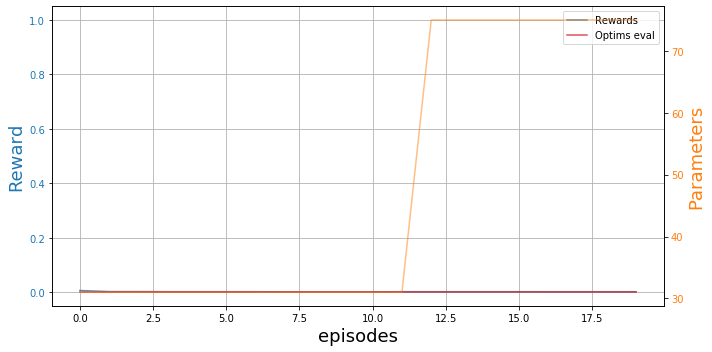

In [ ]:
plot_trainings(results['training'])

## Breadth first search trainer

In [ ]:
#export
def explore_brfs(env, agent, max_states, opt=None, best_ref=None, break_opt=False):
    "Space exploration with Breadth First Search (BrFS)"
    state_count = 0
    breaking = False
    visited_states, energies, parameters, rewards, optims = [], [], [], [], []
    while state_count < max_states:
        expanded_states = agent.expand()
        for state in expanded_states: 
            env.state = state
            simp_state, _ = env._simplify_constraints()
            if not agent.in_closed(simp_state) and not agent.in_open(simp_state):
                energy, params, err = env.get_values()
                if not err: 
                    agent.add_open(simp_state)
                    state_count += 1
                    # Track quantities
                    visited_states.append(simp_state)
                    energies.append(energy)
                    parameters.append(params)
                    if opt is not None: optims.append(check_optim(opt, energy, params))
                    if best_ref is not None: 
                        rewards.append(get_reward(env, energy, params, best_ref=best_ref))
                    if break_opt and check_optim(opt, energy, params): breaking = True; break
        
                else: 
                    agent.add_closed(simp_state)

        if breaking or len(expanded_states) is 0: break
            
    env.save_memory()
    return agent, env, visited_states, energies, parameters, rewards, optims 

class BrFSTrainer:
    def __init__(self, N, H, budget_profile, reward_fun="energy_norm", n_agents=1, n_jobs=1):
        self.env = SDPEnvironment(N, H, budget_profile, reward_criterion=reward_fun)
        self.n_agents = n_agents
        self.parallel = Parallel(n_jobs=n_jobs)
        self.reset()
    
    @delegates(explore_brfs)
    def train(self, max_states, **kwargs):
        "Performs `n_trains` in parallel."
        self.reset() # provisional fix while parallel does not work
        train_setups = zip(self.envs, self.agents)
        p_explore = partial(explore_brfs, max_states=max_states, **kwargs)
        results = self.parallel(delayed(p_explore)(env, agent) for k, (env, agent) in enumerate(train_setups))
        return self._process_results(results) 
        
    def reset(self):
        "Restarts the agents and everinoments creating `n_agents` instances"
        self.agents = [self._get_agent() for _ in range(self.n_agents)]
        self.envs = [deepcopy(self.env) for _ in range(self.n_agents)]
        
    def _process_results(self, results):
        "Processes the results as they come out of the parallel"
        agents, envs, visited_states, energies, params, rewards, optims = [], [], [], [], [], [], []
        for res in results:
            agent, env, states, ener, par, rew, opts = res
            agents.append(agent); envs.append(env); visited_states.append(states); 
            energies.append(ener); params.append(par); rewards.append(rew); optims.append(opts);   
        
        self.agents, self.envs = agents, envs
        return {'agents': agents, 'envs': envs, 'visited_states': visited_states, 
                'energies': energies, 'params': params, 'oracle_rewards': rewards, 'optims': optims}
        
    def _get_agent(self):
        "Instantiates an agent."
        return BrFSAgent(self.env.N, self.env.state)       

In [ ]:
bfs = BrFSTrainer(N, H, profile)

In [ ]:
results = bfs.train(150, opt=opt, best_ref=best_ref)

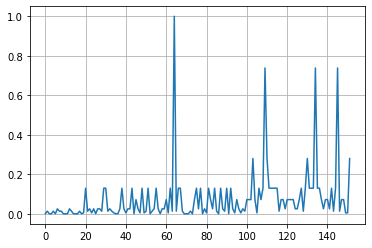

In [ ]:
plt.plot(np.mean(results["oracle_rewards"], axis=0))
plt.grid()

## Monte-Carlo trainer


In [ ]:
#export
def explore_mc(env, agent, max_states, opt=None, best_ref=None, ckp=20, break_opt=False):
    "Space exploration with Monte-Carlo (MC)"
    visited_states, energies, parameters, oracle_rewards, visited_rewards, optims = [], [], [], [], [], []
    breaking = False
    # Initial state
    state = env.reset()
    energy1, params1, _ = env.get_values()
    for s in tqdm(range(max_states)):
        state = deepcopy(state)       
        next_state, action, energy2, params2, err = step(state, agent, env)        
        r1 = get_reward(env, energy1, params1)
        r2 = get_reward(env, energy2, params2)
        
        if not state_in_list(next_state, visited_states):
            if err: raise Exception(f"Got an error for state {next_state}")
            visited_states.append(deepcopy(next_state))
            energies.append(energy2)
            parameters.append(params2)
            visited_rewards.append(r2)
            if opt is not None: optims.append(check_optim(opt, energy2, params2))
            if best_ref is not None: 
                oracle_rewards.append(get_reward(env, energy2, params2, best_ref=best_ref))
            if break_opt and check_optim(opt, energy2, params2): breaking = True; break
        if breaking: break
                
        if agent.accept(r1, r2):
            state = deepcopy(next_state)
            energy1, params1 = deepcopy(energy2), deepcopy(params2)
        else: 
            env.state = deepcopy(state)
            
        if s%ckp == 0: env.save_memory()
                          
    env.save_memory()
    return agent, env, visited_states, energies, parameters, oracle_rewards, visited_rewards, optims

class MCTrainer:
    @delegates(MCAgent.__init__)
    def __init__(self, N, H, budget_profile, reward_fun="energy_norm", n_agents=1, n_jobs=1, **kwargs):
        self.env = SDPEnvironment(N, H, budget_profile, reward_criterion=reward_fun)
        self.n_agents = n_agents
        self.parallel = Parallel(n_jobs=n_jobs)
        self.agent_kwargs = kwargs
        self.reset()
        
    @delegates(explore_mc)
    def train(self, max_states, **kwargs):
        "Performs `n_trains` in parallel."
        train_setups = zip(self.envs, self.agents)
        p_explore = partial(explore_mc, max_states=max_states, **kwargs)
        results = self.parallel(delayed(p_explore)(env, agent) for k, (env, agent) in enumerate(train_setups))
        return self._process_results(results) 
        
    def reset(self):
        "Restarts the agents and everinoments creating `n_agents` instances"
        self.agents = [self._get_agent() for _ in range(self.n_agents)]
        self.envs = [deepcopy(self.env) for _ in range(self.n_agents)]
        
    def _process_results(self, results):
        "Processes the results as they come out of the parallel"
        agents, envs, visited_states, visited_energies, visited_params = [], [], [], [], []
        oracle_rewards, visited_rewards, optims = [], [], []
        for result in results:
            agent, env, states, energies, params, o_rewards, env_rewards, opts = result
            agents.append(agent); envs.append(env); visited_states.append(states); 
            visited_energies.append(energies); visited_params.append(params)
            oracle_rewards.append(o_rewards); visited_rewards.append(env_rewards); optims.append(opts)
            
        self.agents, self.envs = agents, envs
        return {'agents': agents, 'envs': envs, 'visited_states': visited_states, 
                'energies': visited_energies, 'params': visited_params, 'oracle_rewards': oracle_rewards, 
                'visited_rewards': visited_rewards, 'expl_optims': optims}

    def _get_agent(self):
        "Instantiates an agent."
        return MCAgent(self.env.N, **self.agent_kwargs)

In [ ]:
bfs = MCTrainer(N, H, profile, n_agents=2, n_jobs=2)

In [ ]:
results = bfs.train(350, opt=opt, best_ref=best_ref)

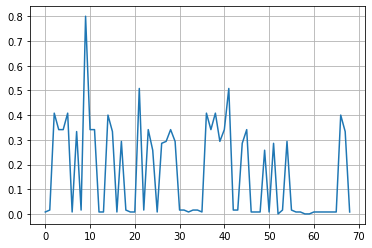

In [ ]:
plt.plot(np.mean(arrange_shape(results['oracle_rewards']), axis=0))
plt.grid()

## Export-

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_environment.ipynb.
Converted 01_agents.ipynb.
Converted 02_budget_profiles.ipynb.
Converted 03_hamiltonian.ipynb.
Converted 04_training.ipynb.
Converted 05_utils.ipynb.
Converted 06_sdp.ipynb.
Converted index.ipynb.
